In [ ]:
import os
import os.path
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import cvxpy as cp

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.getcwd()

'/content'

In [ ]:
! pip install networkx

In [ ]:
! pip install igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 8.2 MB/s eta 0:00:00


In [ ]:
import graphviz
import networkx
import igraph

## Distributing to Consumers While Minimizing Flow Cost
<br>
<font size="+1">
    <ul>
        <li>The following is a classic supply network design problem that involves finding the <i>flow through a network</i> that minimizes the cost of the flow.</li>
        <br>
        <li><b>That is, how to optimally distribute to customers to minimize costs.</b></li>
        <br>
        $\rule{800pt}{10pt}$
        <br>
        <li>Assume we have a set of </li>
        <br>
        <ul>
            <li>factories (manufacturers),</li>
            <br>
            <li>depots (wholesalers / intermediaries),</li>
            <br>
            <li>and customers (retail stores).</li>
            <br>
        </ul>
        <li>Consider the following simplified problem:</li>
        <br>
        <ul>
            <li>We have $6$ customers, which are retail stores, with a known demand.</li>
            <br>
            <li>Customer demand has to be met by some combination of $4$ depots and $2$ factories.</li>
            <br>
            <li>Each depot has a maximum supply capacity, called throughput, and each factory can only produce a certain amount of the product.</li>
            <br>
            <li>Additionally, there is a cost from transporting the product from factories to depots, from factories to customers, and from depots to customers.</li>
            <br>
            <font color="blue"><li style="color:blue">The goal is to minimize the total transportation costs while satisfying the demand from the retail stores and with the capacity limits from the factories and depot throughput.</li></font>
            <br>
        </ul>
        <font color="red"><li style="color:red">Given a supply chain network, how should I best distribute to customers given I want to meet their demand and minimize my costs?</li></font>
        <br>
        <li>The next step consists of determining the decision variables, objective function, and constraint functions.</li>
        <br>
    </ul>
</font>

$\square$

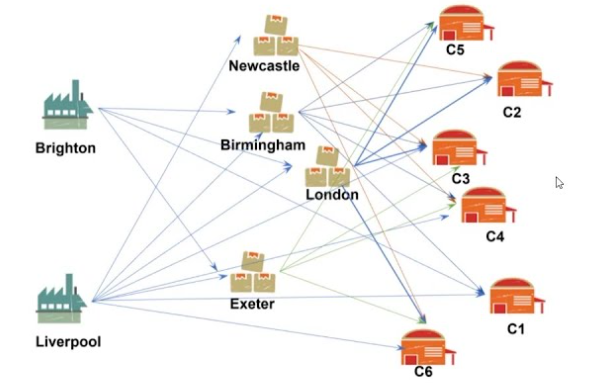

In [ ]:
# Supply Chain Network Design
tf.keras.preprocessing.image.load_img(os.path.join(images_path, 'Supply_Network_Design.png'))

### Network Structure and Parameter Estimation
<br>
<font size="+1">
    <ul>
        <li>The supply network has two factories, in Liverpool and Brighton, which produce a product.</li>
        <br>
        <ul>
            <li>$f \in \text{Factories}=\{\text{Liverpool}, \text{Brighton}\} $</li>
            <br>
            <li>Note: $\in$ is read as <i>in</i>.</li>
            <br>
        </ul>
        <li>Each factory has a maximum production capacity.</li>
        <br>
        <li><table>
  <tr>
    <th>Factory </th>
    <th>Supply (tons)</th>
  </tr>
  <tr>
    <td>Liverpool</td>
    <td>150,000</td>
  </tr>
            <tr>
    <td>Brighton</td>
    <td>200,000</td>
  </tr>
            </table></li>
        <br>
        <ul>
            <li>$\text{supply}_f \in \mathbb{R}_{\geq 0}$: Maximum possible supply from factory $f$ (in tons).</li>
            <br>
        </ul>
        <li>The product can be shipped from a factory to a set of four depots.</li>
        <br>
        <ul>
            <li>$d \in \text{Depots}=\{\text{Newcastle}, \text{Birmingham}, \text{London}, \text{Exeter}\}$</li>
            <br>
        </ul>
        <li>Each depot has a maximum throughput.</li>
        <br>
        <li>Depots don't produce or consume product, the simply pass the product on to customers and act as an intermediary.</li>
        <br>
        <li><table>
  <tr>
    <th>Depot</th>
    <th>Throughput (tons)</th>
  </tr>
  <tr>
    <td>Newcastle</td>
    <td>70,000</td>
  </tr>
            <tr>
    <td>Birmingham</td>
    <td>50,000</td>
  </tr>
            <tr>
    <td>London</td>
    <td>100,000</td>
  </tr>
            <tr>
    <td>Exeter</td>
    <td>40,000</td>
  </tr>
            </table></li>
        <br>
        <ul>
            <li>$\text{throughput}_d \in \mathbb{R}_{\geq 0}$: Maximum possible flow through depot $d$ (in tons).</li>
            <br>
        </ul>
        <li>Our network has six customers.</li>
        <br>
        <ul>
            <li>$c \in \text{Customers}=\{\text{C1}, \text{C2}, \text{C3}, \text{C4}, \text{C5}, \text{C6}\}$</li>
            <br>
        </ul>
        <li>Each customer has an estimated demand of:</li>
        <br>
        <li><table>
  <tr>
    <th>Customer</th>
    <th>Demand (tons)</th>
  </tr>
  <tr>
    <td>Customer 1</td>
    <td>50,000</td>
  </tr>
            <tr>
    <td>Customer 2</td>
    <td>10,000</td>
  </tr>
            <tr>
    <td>Customer 3</td>
    <td>40,000</td>
  </tr>
            <tr>
    <td>Customer 4</td>
    <td>35,000</td>
  </tr>
            <tr>
    <td>Customer 5</td>
    <td>60,000</td>
  </tr>
            <tr>
    <td>Customer 6</td>
    <td>20,000</td>
  </tr>
            </table></li>
        <br>
        <ul>
            <li>$\text{demand}_c \in \mathbb{R}_{\geq 0}$: Demand for product at customer $c$ (in tons).</li>
            <br>
        </ul>
        <li>The network has shipping costs between factories and depots, factories and customers, and depots and customers.</li>
        <br>
        <ul>
            <li>$\text{Cities} = \text{Factories} \cup \text{Depots} \cup \text{Customers}$</li>
            <br>
        </ul>
        <li>The following table gives the shipping costs.</li>
        <br>
        <ul>
            <li>$\text{cost}_{i,j} \in \mathbb{R}_{\geq 0}$: Cost of shipping one ton from source $i$ to destination $j$.</li>
            <br>
            <li>Rows are source cities and columns are destination cities.</li>
            <br>
            <li>Thus, for example, it costs 1 dollar per ton to ship the product from Liverpool to London.</li>
            <br>
            <li>A '-' in the table indicates that that combination is not possible, so for example it is not possible to ship from the factory in Brighton to the depot in Newcastle.</li>
            <br>
        </ul>
        <li>The entries in the following table are in units of dollars per ton:</li>
        <br>
    </ul>
</font>

| From \ To           | Newcastle | Birmingham | London | Exeter | Customer 1 | Customer 2 | Customer 3 | Customer 4 | Customer 5 | Customer 6 |
|---------------------|-----------|------------|--------|--------|------------|------------|------------|------------|------------|------------|
| Liverpool (factory) | 0.5       | 0.5        | 1.0    | 0.2    | 1.0        |     -      | 1.5        | 2.0        |     -      | 1.0        |
| Brighton (factory)  |     -     | 0.3        | 0.5    | 0.2    | 2.0        |     -      |     -      |     -      |     -      |     -      |
| Newcastle (depot)   |     -     |     -      |   -    |   -    |     -      | 1.5        | 0.5        | 1.5        |     -      | 1.0        |
| Birmingham (depot)  |     -     |     -      |   -    |   -    | 1.0        | 0.5        | 0.5        | 1.0        | 0.5        |     -      |
| London (depot)      |     -     |     -      |   -    |   -    |     -      | 1.5        | 2.0        |     -      | 0.5        | 1.5        |
| Exeter (depot)      |     -     |     -      |   -    |   -    |     -      |     -      | 0.2        | 1.5        | 0.5        | 1.5        |

$\square$

<br>
<br>
<font size="+1">
    <ul>
        <li>We can think of this table of costs as a <a href="https://en.wikipedia.org/wiki/Matrix_(mathematics)">matrix</a> of costs.</li>
        <br>
        <li>
        \begin{equation}
        \text{cost} = \begin{bmatrix}\text{cost}_{1,1} & \text{cost}_{1,2} & \cdots & \text{cost}_{1,10} \\
        \text{cost}_{2,1} & \text{cost}_{2,2} & \cdots & \text{cost}_{2,10} \\
        \vdots & \vdots & \cdots & \vdots \\
        \text{cost}_{6,1} & \text{cost}_{6,2} & \cdots & \text{cost}_{6,10} \\
        \end{bmatrix}
        \end{equation}
        </li>
        <br>
        <font color="red"><li style="color:red">For us, the following parameters are given.</li>
        <br>
        <li style="color:red">However, in practice these quantities would have to be estimated/forecasted using predictive machine learning methods. </li></font>
        <br>
    </ul>
</font>

$\square$

In [ ]:
# Goal: Find the flow that minimizes the the total cost of the flow going through a network
# You are given a set of factories, depots, and customers,
# what's the best way to satisfy customer demand while minimizing shipping costs?

# Given a supply chain network, how should I best distribute to customers given I want to meet their demand
# and minimize my costs

# The question to be answered is how to satisfy the demands of the end customers
# while minimizing shipping costs.

### Decision Variables
<br>
<font size="+1">
    <ul>
        <li>What decisions do you, the supply chain manager, have to make, i.e. what is in your control?</li>
        <br>
        <li>You have to decide how many units to ship from each factory or depot to the set of customers.</li>
        <br>
        <ul>
            <li>The decision variables are the flow from a source to a destination.</li>
            <br>
            <li>$\text{flow}_{i,j} \in \mathbb{Z}_{\geq 0}$: Quantity of product (in tons) that is shipped from source $i$ to destination $j$.</li>
            <br>
            <ul>
                <li>note this is discrete variable </li>
                <br>
            </ul>
            <li>We can think of the decision variables of flows as a <a href="https://en.wikipedia.org/wiki/Matrix_(mathematics)">matrix</a> of flows.</li>
        <br>
        <li>
        \begin{equation}
        \text{flow} = \begin{bmatrix}\text{flow}_{1,1} & \text{flow}_{1,2} & \cdots & \text{flow}_{1,10} \\
        \text{flow}_{2,1} & \text{flow}_{2,2} & \cdots & \text{flow}_{2,10} \\
        \vdots & \vdots & \cdots & \vdots \\
        \text{flow}_{6,1} & \text{flow}_{6,2} & \cdots & \text{flow}_{6,10} \\
        \end{bmatrix}
        \end{equation}</li>
        <br>
        </ul>
        <li>Now, we can instantiate a CVXPY variable object to represent the decision variables.</li>
        <br>
    </ul>
</font>

$\square$

In [ ]:
import cvxpy as cp
import numpy as np
import pandas as pd

<br>
<font size="+1">
    <ul>
        <li>The supply, depot, and demand data frames are used as coefficients in the constraint functions.</li>
        <br>
    </ul>
</font>

In [ ]:
# Create data frame to capture factory supply limits

supply = pd.DataFrame({'Liverpool': 150000,
                     'Brighton': 200000},
                      index=['supply_limits']).T

supply

,supply_limits
Liverpool,150000
Brighton,200000


In [ ]:
# Create data frame to capture depot throughput limits

depot = pd.DataFrame({'Newcastle': 70000,
                    'Birmingham': 50000,
                    'London': 100000,
                    'Exeter': 40000},
                     index=['depot_limits']).T

depot

,depot_limits
Newcastle,70000
Birmingham,50000
London,100000
Exeter,40000


In [ ]:
# Create data frame to caputure customer demand

demand = pd.DataFrame({'C1': 50000,
               'C2': 10000,
               'C3': 40000,
               'C4': 35000,
               'C5': 60000,
               'C6': 20000},
                      index=['demand']).T

demand

,demand
C1,50000
C2,10000
C3,40000
C4,35000
C5,60000
C6,20000


<br>
<font size="+1">
    <ul>
        <li>Objective coefficients are provided below in the $\text{costs}$ data frame.</li>
        <br>
    </ul>
</font>

$\square$

In [ ]:
# Create a data frame to capture shipping costs.

costs = pd.DataFrame({
    ('Liverpool', 'Newcastle'): 0.5,
    ('Liverpool', 'Birmingham'): 0.5,
    ('Liverpool', 'London'): 1.0,
    ('Liverpool', 'Exeter'): 0.2,
    ('Liverpool', 'C1'): 1.0,
    ('Liverpool', 'C3'): 1.5,
    ('Liverpool', 'C4'): 2.0,
    ('Liverpool', 'C6'): 1.0,
    ('Brighton', 'Birmingham'): 0.3,
    ('Brighton', 'London'): 0.5,
    ('Brighton', 'Exeter'): 0.2,
    ('Brighton', 'C1'): 2.0,
    ('Newcastle', 'C2'): 1.5,
    ('Newcastle', 'C3'): 0.5,
    ('Newcastle', 'C5'): 1.5,
    ('Newcastle', 'C6'): 1.0,
    ('Birmingham', 'C1'): 1.0,
    ('Birmingham', 'C2'): 0.5,
    ('Birmingham', 'C3'): 0.5,
    ('Birmingham', 'C4'): 1.0,
    ('Birmingham', 'C5'): 0.5,
    ('London', 'C2'): 1.5,
    ('London', 'C3'): 2.0,
    ('London', 'C5'): 0.5,
    ('London', 'C6'): 1.5,
    ('Exeter', 'C3'): 0.2,
    ('Exeter', 'C4'): 1.5,
    ('Exeter', 'C5'): 0.5,
    ('Exeter', 'C6'): 1.5
}, index=['costs']).T

costs

costs
Liverpool  Newcastle     0.5
           Birmingham    0.5
           London        1.0
           Exeter        0.2
           C1            1.0
           C3            1.5
           C4            2.0
           C6            1.0
Brighton   Birmingham    0.3
           London        0.5
           Exeter        0.2
           C1            2.0
Newcastle  C2            1.5
           C3            0.5
           C5            1.5
           C6            1.0
Birmingham C1            1.0
           C2            0.5
           C3            0.5
           C4            1.0
           C5            0.5
London     C2            1.5
           C3            2.0
           C5            0.5
           C6            1.5
Exeter     C3            0.2
           C4            1.5
           C5            0.5
           C6            1.5

In [ ]:
# Could also fill with a very large number (proxy for infinty)
# that acts as a penalty for routing any flow in that edge (arc)

# costs = costs.unstack().fillna(0)
infinity_proxy = 1_000_000 # np.inf
costs = costs.unstack().fillna(infinity_proxy) #.fillna(np.inf)

costs

costs                                                         \
           Birmingham         C1         C2         C3         C4         C5   
Birmingham  1000000.0        1.0        0.5        0.5        1.0        0.5   
Brighton          0.3        2.0  1000000.0  1000000.0  1000000.0  1000000.0   
Exeter      1000000.0  1000000.0  1000000.0        0.2        1.5        0.5   
Liverpool         0.5        1.0  1000000.0        1.5        2.0  1000000.0   
London      1000000.0  1000000.0        1.5        2.0  1000000.0        0.5   
Newcastle   1000000.0  1000000.0        1.5        0.5  1000000.0        1.5   

                                                        
                   C6     Exeter     London  Newcastle  
Birmingham  1000000.0  1000000.0  1000000.0  1000000.0  
Brighton    1000000.0        0.2        0.5  1000000.0  
Exeter            1.5  1000000.0  1000000.0  1000000.0  
Liverpool         1.0        0.2        1.0        0.5  
London            1.5  1000000.0  1000000.0  1000000.0  
Newcastle         1.0  1000000.0  1000000.0  1000000.0

In [ ]:
costs.shape

(6, 10)

<br>
<font size="+1">
    <ul>
        <li>The decision variables capture the amount of product that flows along each allowed path between a source and destination.</li>
        <br>
    </ul>
</font>

In [ ]:
flow = cp.Variable(costs.shape, integer=True)

In [ ]:
flow.shape

(6, 10)

### Objective Function
<br>
<font size="+1">
    <ul>
        <li>What's the goal?</li>
        <br>
        <li>The goal is to minimize the total shipping costs, $$\text{minimize: } C = \sum_{(i,j) \in \text{Cities} \times \text{Cities}}{\text{cost}_{i,j}\times \text{flow}_{i,j}}$$</li>
        <br>
        <li>Now, we can instantiate a CVXPY objective function.</li>
        <br>
        <font color="blue"><li style="color:blue">NOT NECESSARY TO KNOW: </li></font>
        <br>
        <ul style="color:blue">
            <font color="blue"><li>This is technically the <a href="https://en.wikipedia.org/wiki/Hadamard_product_(matrices)">Hadamard product</a> (also known as the element-wise product) of the costs and flow tables (matrices).</li>
            <br>
            <li>
            \begin{equation}
            \text{cost}\circ\text{flow} = \begin{bmatrix}\text{cost}_{1,1} & \text{cost}_{1,2} & \cdots & \text{cost}_{1,10} \\
        \text{cost}_{2,1} & \text{cost}_{2,2} & \cdots & \text{cost}_{2,10} \\
        \vdots & \vdots & \cdots & \vdots \\
        \text{cost}_{6,1} & \text{cost}_{6,2} & \cdots & \text{cost}_{6,10} \\
        \end{bmatrix} \circ \begin{bmatrix}\text{flow}_{1,1} & \text{flow}_{1,2} & \cdots & \text{flow}_{1,10} \\
        \text{flow}_{2,1} & \text{flow}_{2,2} & \cdots & \text{flow}_{2,10} \\
        \vdots & \vdots & \cdots & \vdots \\
        \text{flow}_{6,1} & \text{flow}_{6,2} & \cdots & \text{flow}_{6,10} \\
        \end{bmatrix} \\
        = \begin{bmatrix}\text{cost}_{1,1} \text{flow}_{1,1} & \text{cost}_{1,2}\text{flow}_{1,2} & \cdots & \text{cost}_{1,10}\text{flow}_{1,10} \\
        \text{cost}_{2,1}\text{flow}_{2,1} & \text{cost}_{2,2}\text{flow}_{2,2} & \cdots & \text{cost}_{2,10}\text{flow}_{2,10} \\
        \vdots & \vdots & \cdots & \vdots \\
        \text{cost}_{6,1}\text{flow}_{6,1} & \text{cost}_{6,2}\text{flow}_{6,2} & \cdots & \text{cost}_{6,10}\text{flow}_{6,10}  \\
        \end{bmatrix}
        \end{equation}</li>
            <br>
            <li>Then the total costs is the sum of all elements in the matrix $$\text{cost}\circ\text{flow},$$ which equals $$\sum_{i \in \text{Rows}} \sum_{j \in \text{Columns}} \text{cost}_{i,j} \text{flow}_{i,j}.$$</li>
            <br></font>
        </ul>
    </ul>
</font>

$\square$

In [ ]:
num_rows = costs.shape[0]

num_columns = costs.shape[1]

[costs.values[i,j]*flow[i,j] for i in range(num_rows) for j in range(num_columns)]

## cp.multiply(costs, flow)

[Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AFFINE, UNKNOWN, ()),
 Expression(AF

In [ ]:
total_flow_cost = sum([costs.values[i,j]*flow[i,j] for i in range(num_rows) for j in range(num_columns)])

In [ ]:
print(total_flow_cost)

1000000.0 @ var1[0, 0] + 1.0 @ var1[0, 1] + 0.5 @ var1[0, 2] + 0.5 @ var1[0, 3] + 1.0 @ var1[0, 4] + 0.5 @ var1[0, 5] + 1000000.0 @ var1[0, 6] + 1000000.0 @ var1[0, 7] + 1000000.0 @ var1[0, 8] + 1000000.0 @ var1[0, 9] + 0.3 @ var1[1, 0] + 2.0 @ var1[1, 1] + 1000000.0 @ var1[1, 2] + 1000000.0 @ var1[1, 3] + 1000000.0 @ var1[1, 4] + 1000000.0 @ var1[1, 5] + 1000000.0 @ var1[1, 6] + 0.2 @ var1[1, 7] + 0.5 @ var1[1, 8] + 1000000.0 @ var1[1, 9] + 1000000.0 @ var1[2, 0] + 1000000.0 @ var1[2, 1] + 1000000.0 @ var1[2, 2] + 0.2 @ var1[2, 3] + 1.5 @ var1[2, 4] + 0.5 @ var1[2, 5] + 1.5 @ var1[2, 6] + 1000000.0 @ var1[2, 7] + 1000000.0 @ var1[2, 8] + 1000000.0 @ var1[2, 9] + 0.5 @ var1[3, 0] + 1.0 @ var1[3, 1] + 1000000.0 @ var1[3, 2] + 1.5 @ var1[3, 3] + 2.0 @ var1[3, 4] + 1000000.0 @ var1[3, 5] + 1.0 @ var1[3, 6] + 0.2 @ var1[3, 7] + 1.0 @ var1[3, 8] + 0.5 @ var1[3, 9] + 1000000.0 @ var1[4, 0] + 1000000.0 @ var1[4, 1] + 1.5 @ var1[4, 2] + 2.0 @ var1[4, 3] + 1000000.0 @ var1[4, 4] + 0.5 @ var1[4,

In [ ]:
objective_function = cp.Minimize(total_flow_cost)

### Constraint Functions
<br>
<font size="+1">
    <ul>
        <font color="blue"><li style="color:blue">Recall, the goal is to minimize the total transportation costs while satisfying the demand from the retail stores and with the capacity limits from the factories and depot throughput.</li></font>
            <br>
        <br>
        <li>Constraints:</li>
        <br>
        <ul>
            <li>Our first constraints require the total flow leaving a factory to be at most as large as the supply capacity of that factory.</li>
            <br>
            <li>Our next constraints require the total flow being distributed to a customer to be equal to the demand from that customer.</li>
            <br>
            <li>Our final constraints relate to depots.</li>
            <br>
            <ul>
                <li>The third set of constraints require that the total amount of product entering the depot must equal the total amount leaving, that is, being distributed to a customer.</li>
                <br>
                <li>The fourth set of constraints limits the product passing through the depot to be at most equal the throughput of that depot.</li>
                <br>
            </ul>
        </ul>
        <li>This results in $4$ classes of constraints, with each constraint within that class being specific to the particular factory, depot, or customer.</li>
        <br>
        <font color="dodgerblue"><li style="color:dodgerblue">Recall: </li></font>
        <br>
        <ul style="color:dodgerblue">
            <font color="dodgerblue"><li>$\text{Factories}=\{\text{Liverpool}, \text{Brighton}\} $</li>
                <br>
                <li>$\text{Depots}=\{\text{Newcastle}, \text{Birmingham}, \text{London}, \text{Exeter}\}$</li>
                <br>
                <li>$\text{Customers}=\{\text{C1}, \text{C2}, \text{C3}, \text{C4}, \text{C5}, \text{C6}\}$</li>
                <br>
                <li>$\text{Cities} = \text{Factories} \cup \text{Depots} \cup \text{Customers}$</li>
                <br></font>
        </ul>
        <li>We can now model our constraints as follows:</li>
        <br>
        <ul>
            <li><b>Factory output:</b> Flow of product from a factory must respect maximum capacity.
                \begin{equation}
                \sum_{j \in \text{Depots} \cup \text{Customers}}{\text{flow}_{i,j}} \leq \text{supply}_{i} \quad \forall i \in \text{Factories}
                \end{equation}</li>
            <br>
            <li><b>Customer demand:</b> Flow of goods must meet customer demand.
                \begin{equation}
                \sum_{i \in  \text{Factories} \cup \text{Depots}}{\text{flow}_{i,j}} = \text{demand}_{j} \quad \forall j \in \text{Customers}
                \end{equation}</li>
            <br>
            <li><b>Depot flow:</b> Flow into a depot equals flow out of the depot.
            \begin{equation}
            \sum_{i \in \text{Factories}}{\text{flow}_{i,j}} =
\sum_{k \in \text{Customers}}{\text{flow}_{j,k}}
\quad \forall j \in \text{Depots}
            \end{equation}</li>
            <br>
            <li><b>Depot capacity:</b> Flow into a depot must respect depot capacity.
            \begin{equation}
            \sum_{i \in \text{Factories}}{\text{flow}_{i,j}} \leq \text{throughput}_{j}
\quad \forall j \in \text{Depots}
            \end{equation}</li>
            <br>
        </ul>
        <font color="blue"><li style="color:blue">These yield the following problem:
            \begin{align}\text{minimize: }& \sum_{(i,j) \in \text{Cities} \times \text{Cities}}{\text{cost}_{i,j}\times \text{flow}_{i,j}}\\ \\
            \text{subject to: } & \sum_{j \in \text{Depots} \cup \text{Customers}}{\text{flow}_{i,j}} \leq \text{supply}_{i} \quad \forall i \in \text{Factories}\\
            & \sum_{i \in  \text{Factories} \cup \text{Depots}}{\text{flow}_{i,j}} = \text{demand}_{j} \quad \forall j \in \text{Customers} \\
            & \sum_{i \in \text{Factories}}{\text{flow}_{i,j}} =
\sum_{k \in \text{Customers}}{\text{flow}_{j,k}}
\quad \forall j \in \text{Depots} \\
            & \sum_{i \in \text{Factories}}{\text{flow}_{i,j}} \leq \text{throughput}_{j}
\quad \forall j \in \text{Depots} \\ \end{align}</li></font>
        <br>
    </ul>
</font>

$\square$

<br>
<font size="+1">
    <ul>
        <li>The supply, depot, and demand data frames are used as parameters in the constraint functions.</li>
        <br>
    </ul>
</font>

In [ ]:
supply

,supply_limits
Liverpool,150000
Brighton,200000


In [ ]:
depot

,depot_limits
Newcastle,70000
Birmingham,50000
London,100000
Exeter,40000


In [ ]:
demand

,demand
C1,50000
C2,10000
C3,40000
C4,35000
C5,60000
C6,20000


In [ ]:
costs.replace({infinity_proxy :np.nan})

costs                                                      
           Birmingham   C1   C2   C3   C4   C5   C6 Exeter London Newcastle
Birmingham        NaN  1.0  0.5  0.5  1.0  0.5  NaN    NaN    NaN       NaN
Brighton          0.3  2.0  NaN  NaN  NaN  NaN  NaN    0.2    0.5       NaN
Exeter            NaN  NaN  NaN  0.2  1.5  0.5  1.5    NaN    NaN       NaN
Liverpool         0.5  1.0  NaN  1.5  2.0  NaN  1.0    0.2    1.0       0.5
London            NaN  NaN  1.5  2.0  NaN  0.5  1.5    NaN    NaN       NaN
Newcastle         NaN  NaN  1.5  0.5  NaN  1.5  1.0    NaN    NaN       NaN

In [ ]:
# Production capacity limits

# factory_output_constraints = [sum([flow[1, j] for j in [0,1,7,8]]) <= supply.loc['Brighton', 'supply_limits'],
#                               sum([flow[3, j] for j in [0,1,3,4,6,7,8,9]]) <= supply.loc['Liverpool', 'supply_limits']]

factory_output_constraints = [sum([flow[1, j] for j in range(num_columns)]) <= supply.loc['Brighton', 'supply_limits'],
                              sum([flow[3, j] for j in range(num_columns)]) <= supply.loc['Liverpool', 'supply_limits']]

factory_output_constraints

[Inequality(Expression(AFFINE, UNKNOWN, ())),
 Inequality(Expression(AFFINE, UNKNOWN, ()))]

In [ ]:
# Customer demand

# customer_demand_constraints = [sum([flow[i, 1] for i in [0,1,3]]) == demand.loc['C1', 'demand'],
#                               sum([flow[i, 2] for i in [0,4,5]]) == demand.loc['C2', 'demand'],
#                               sum([flow[i, 3] for i in [0,2,3,4,5]]) == demand.loc['C3', 'demand'],
#                               sum([flow[i, 4] for i in [0,2,3]]) == demand.loc['C4', 'demand'],
#                               sum([flow[i, 5] for i in [0,2,4,5]]) == demand.loc['C5', 'demand'],
#                               sum([flow[i, 6] for i in [2,3,4,5]]) == demand.loc['C6', 'demand']]

customer_demand_constraints = [sum([flow[i, 1] for i in range(num_rows)]) == demand.loc['C1', 'demand'],
                              sum([flow[i, 2] for i in range(num_rows)]) == demand.loc['C2', 'demand'],
                              sum([flow[i, 3] for i in range(num_rows)]) == demand.loc['C3', 'demand'],
                              sum([flow[i, 4] for i in range(num_rows)]) == demand.loc['C4', 'demand'],
                              sum([flow[i, 5] for i in range(num_rows)]) == demand.loc['C5', 'demand'],
                              sum([flow[i, 6] for i in range(num_rows)]) == demand.loc['C6', 'demand']]

customer_demand_constraints

[Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, NONNEGATIVE, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, NONNEGATIVE, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, NONNEGATIVE, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, NONNEGATIVE, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, NONNEGATIVE, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, NONNEGATIVE, ()))]

In [ ]:
# Depot flow conservation

# depot_flow_constraints = [sum([flow[i, 0] for i in [1, 3]]) == sum([flow[0, k] for k in [1,2,3,4,5]]),
#                          sum([flow[i, 7] for i in [1,3]]) == sum([flow[2, k] for k in [3,4,5,6]]),
#                          sum([flow[i, 8] for i in [1,3]]) == sum([flow[4, k] for k in [2,3,5,6]]),
#                          sum([flow[i, 9] for i in [3]]) == sum([flow[5, k] for k in [2,3,5,6]])]

depot_flow_constraints = [sum([flow[i, 0] for i in range(num_rows)]) == sum([flow[0, k] for k in range(num_columns)]),
                         sum([flow[i, 7] for i in range(num_rows)]) == sum([flow[2, k] for k in range(num_columns)]),
                         sum([flow[i, 8] for i in range(num_rows)]) == sum([flow[4, k] for k in range(num_columns)]),
                         sum([flow[i, 9] for i in range(num_rows)]) == sum([flow[5, k] for k in range(num_columns)])]

depot_flow_constraints

[Equality(Expression(AFFINE, UNKNOWN, ()), Expression(AFFINE, UNKNOWN, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Expression(AFFINE, UNKNOWN, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Expression(AFFINE, UNKNOWN, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Expression(AFFINE, UNKNOWN, ()))]

In [ ]:
# Depot throughput

# depot_throughput_constraints = [sum([flow[i, 0] for i in [1, 3]]) <= depot.loc['Birmingham','depot_limits'],
#                          sum([flow[i, 7] for i in [1,3]]) <= depot.loc['Exeter','depot_limits'],
#                          sum([flow[i, 8] for i in [1,3]]) <= depot.loc['London','depot_limits'],
#                          sum([flow[i, 9] for i in [3]]) <= depot.loc['Newcastle','depot_limits']]

depot_throughput_constraints = [sum([flow[i, 0] for i in range(num_rows)]) <= depot.loc['Birmingham','depot_limits'],
                         sum([flow[i, 7] for i in range(num_rows)]) <= depot.loc['Exeter','depot_limits'],
                         sum([flow[i, 8] for i in range(num_rows)]) <= depot.loc['London','depot_limits'],
                         sum([flow[i, 9] for i in range(num_rows)]) <= depot.loc['Newcastle','depot_limits']]

depot_throughput_constraints

[Inequality(Expression(AFFINE, UNKNOWN, ())),
 Inequality(Expression(AFFINE, UNKNOWN, ())),
 Inequality(Expression(AFFINE, UNKNOWN, ())),
 Inequality(Expression(AFFINE, UNKNOWN, ()))]

In [ ]:
constraints = factory_output_constraints\
+customer_demand_constraints\
+depot_flow_constraints\
+depot_throughput_constraints\
+[flow>=0]
# +no_connection_constraint\
# +[flow>=0]

In [ ]:
constraints

[Inequality(Expression(AFFINE, UNKNOWN, ())),
 Inequality(Expression(AFFINE, UNKNOWN, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, NONNEGATIVE, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, NONNEGATIVE, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, NONNEGATIVE, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, NONNEGATIVE, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, NONNEGATIVE, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, NONNEGATIVE, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Expression(AFFINE, UNKNOWN, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Expression(AFFINE, UNKNOWN, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Expression(AFFINE, UNKNOWN, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Expression(AFFINE, UNKNOWN, ())),
 Inequality(Expression(AFFINE, UNKNOWN, ())),
 Inequality(Expression(AFFINE, UNKNOWN, ())),
 Inequality(Expression

In [ ]:
len(constraints)

17

In [ ]:
problem = cp.Problem(objective_function, constraints)

In [ ]:
print(problem)

minimize 1000000.0 @ var1[0, 0] + 1.0 @ var1[0, 1] + 0.5 @ var1[0, 2] + 0.5 @ var1[0, 3] + 1.0 @ var1[0, 4] + 0.5 @ var1[0, 5] + 1000000.0 @ var1[0, 6] + 1000000.0 @ var1[0, 7] + 1000000.0 @ var1[0, 8] + 1000000.0 @ var1[0, 9] + 0.3 @ var1[1, 0] + 2.0 @ var1[1, 1] + 1000000.0 @ var1[1, 2] + 1000000.0 @ var1[1, 3] + 1000000.0 @ var1[1, 4] + 1000000.0 @ var1[1, 5] + 1000000.0 @ var1[1, 6] + 0.2 @ var1[1, 7] + 0.5 @ var1[1, 8] + 1000000.0 @ var1[1, 9] + 1000000.0 @ var1[2, 0] + 1000000.0 @ var1[2, 1] + 1000000.0 @ var1[2, 2] + 0.2 @ var1[2, 3] + 1.5 @ var1[2, 4] + 0.5 @ var1[2, 5] + 1.5 @ var1[2, 6] + 1000000.0 @ var1[2, 7] + 1000000.0 @ var1[2, 8] + 1000000.0 @ var1[2, 9] + 0.5 @ var1[3, 0] + 1.0 @ var1[3, 1] + 1000000.0 @ var1[3, 2] + 1.5 @ var1[3, 3] + 2.0 @ var1[3, 4] + 1000000.0 @ var1[3, 5] + 1.0 @ var1[3, 6] + 0.2 @ var1[3, 7] + 1.0 @ var1[3, 8] + 0.5 @ var1[3, 9] + 1000000.0 @ var1[4, 0] + 1000000.0 @ var1[4, 1] + 1.5 @ var1[4, 2] + 2.0 @ var1[4, 3] + 1000000.0 @ var1[4, 4] + 0.5 

### Solve the Problem
<br>
<font size="+1">
    <ul>
        <li>This amounts to calling the solve method.</li>
        <br>
    </ul>
</font>

In [ ]:
# ! pip install cvxopt

In [ ]:
cp.installed_solvers()

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCIPY', 'SCS']

In [ ]:
# problem.solve(verbose=True, feastol=1e-54, solver='ECOS_BB')
problem.solve(verbose=True, solver='GLPK_MI')

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Dec 25 05:51:31 PM: Your problem has 60 variables, 17 constraints, and 0 parameters.
(CVXPY) Dec 25 05:51:31 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 25 05:51:31 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 25 05:51:31 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 25 05:51:31 PM: Compiling problem (target solver=GLPK_MI).
(CVXPY) Dec 25 05:51:31 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

198500.0

In [ ]:
problem.value

198500.0

In [ ]:
print(flow.value)

[[    0.     0. 10000.     0. 35000.  5000.     0.     0.     0.     0.]
 [50000.     0.     0.     0.     0.     0.     0.     0. 55000.     0.]
 [    0.     0.     0. 40000.     0.     0.     0.     0.     0.     0.]
 [    0. 50000.     0.     0.     0.     0. 20000. 40000.     0.     0.]
 [    0.     0.     0.     0.     0. 55000.     0.     0.     0.     0.]
 [    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]]


### Analysis
<br>
<font size="+1">
    <ul>
        <li>Product demand from all of our customers can be satisfied for a total cost of $\$198,500$.</li>
        <br>
        <li>The optimal plan is as follows.</li>
        <br>
    </ul>
</font>

$\square$

In [ ]:
costs

costs                                                         \
           Birmingham         C1         C2         C3         C4         C5   
Birmingham  1000000.0        1.0        0.5        0.5        1.0        0.5   
Brighton          0.3        2.0  1000000.0  1000000.0  1000000.0  1000000.0   
Exeter      1000000.0  1000000.0  1000000.0        0.2        1.5        0.5   
Liverpool         0.5        1.0  1000000.0        1.5        2.0  1000000.0   
London      1000000.0  1000000.0        1.5        2.0  1000000.0        0.5   
Newcastle   1000000.0  1000000.0        1.5        0.5  1000000.0        1.5   

                                                        
                   C6     Exeter     London  Newcastle  
Birmingham  1000000.0  1000000.0  1000000.0  1000000.0  
Brighton    1000000.0        0.2        0.5  1000000.0  
Exeter            1.5  1000000.0  1000000.0  1000000.0  
Liverpool         1.0        0.2        1.0        0.5  
London            1.5  1000000.0  1000000.0  1000000.0  
Newcastle         1.0  1000000.0  1000000.0  1000000.0

In [ ]:
costs.columns.get_level_values(1)

Index(['Birmingham', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'Exeter', 'London',
       'Newcastle'],
      dtype='object')

In [ ]:
pd.DataFrame(np.round(flow.value),
             index=costs.index,
             columns=costs.columns.get_level_values(1))

,Birmingham,C1,C2,C3,C4,C5,C6,Exeter,London,Newcastle
Birmingham,0.0,0.0,10000.0,0.0,35000.0,5000.0,0.0,0.0,0.0,0.0
Brighton,50000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55000.0,0.0
Exeter,0.0,0.0,0.0,40000.0,0.0,0.0,0.0,0.0,0.0,0.0
Liverpool,0.0,50000.0,0.0,0.0,0.0,0.0,20000.0,40000.0,0.0,0.0
London,0.0,0.0,0.0,0.0,0.0,55000.0,0.0,0.0,0.0,0.0
Newcastle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
optimal_flow = pd.DataFrame(np.round(flow.value),
                            index=costs.index,
                            columns=costs.columns).stack().rename(columns={'costs':'flow'})

In [ ]:
optimal_flow[optimal_flow['flow']>0]

flow
Birmingham C2          10000.0
           C4          35000.0
           C5           5000.0
Brighton   Birmingham  50000.0
           London      55000.0
Exeter     C3          40000.0
Liverpool  C1          50000.0
           C6          20000.0
           Exeter      40000.0
London     C5          55000.0

In [ ]:
# Note there could be a slight bug in one of the constraints, or numerical instability from the solver algorithm

# First, just about any solver (mosek, ECOS, SCS, gurobi, etc..) has feasibility tolerances.
# If a solution's violation is within some very small tolerance (e.g. 1e-9),
# then those constraint violations are effectively ignored.
# In principle you can prevent this by setting the feasibility tolerance of your solver to zero
# (different solvers do this in different ways).

# However, even setting your feasibility tolerance to zero may not save you here.
# The main purpose of CVXPY is to manage a large number of problem transformations behind-the-scenes,
# so as to pass your problem to a high performance solver with rigid input requirements.
# These transformations are valid in exact arithmetic,
# but they may introduce issues when working with floating point numbers.
# The errors introduced should always be small (say, no larger than 1e-10), but they can be meaningful.

# There has been some discussion around post-solver checks for feasibility (see #434 )
# but it's not clear how far out those might be from a cvxpy release (if it's incorporated at all).

# For now, users should verify or perform projections of a returned solution when feasibility is critical.

## Supply Chain Planning
<br>
<font size="+1">
    <ul>
        <font color="red"><li style="color:red">Warning: This problem is challenging and will not be graded by correctness, but rather effort, give it your best shot.</li></font>
        <br>
        <li>Every time Amazon has to ship an item from its fulfillment centers to a particular region, it incurs a shipping cost.</li>
        <br>
        <li>Consider the following shipping costs from three of Amazon's fulfillment centers (FC) to four regions (A, B, C, and D):</li>
        <br>
        <li><br><table>
  <tr>
    <th>Region \ FC:</th>
    <th>1</th>
    <th>2</th>
      <th>3</th>
  </tr>
  <tr>
    <td>A: King's County, NY</td>
    <td>20</td>
    <td>8</td>
      <td>25</td>
  </tr>
            <tr>
    <td>B: LA County, CA</td>
    <td>18</td>
      <td>23</td>
      <td>8</td>
  </tr>
  <tr>
    <td>C: King County, WA</td>
    <td>21</td>
    <td>24</td>
      <td>8</td>
  </tr>
            <tr>
    <td>D: Harris County, TX</td>
    <td>8</td>
    <td>8</td>
      <td>19</td>
  </tr>
       </table></li>
        <br>
        <li>It costs $20$ dollars to ship from fulfillment center $1$ to region $A$, for example.</li>
        <br>
        <li>We also have weekly demand estimates for the item in each region:</li>
        <br>
        <li>
        <table>
  <tr>
    <th>Region A</th>
    <th>Region B</th>
    <th>Region C</th>
      <th>Region D</th>
  </tr>
             <tr>
    <th>30</th>
    <th>50</th>
    <th>10</th>
      <th>20</th>
            </tr></table></li>
        <br>
        <li>Further, assume each fulfillment center is able to ship up to $40$ units each week in total.</li>
        <br>
        <li>What is the minimum transportation cost needed to satisfy all weekly demand while respecting fulfillment center capacities, as well as the optimal shipment plan?</li>
        <br>
        <font color="red"><li style="color:red">In other words, what is the shipment plan (i.e. number of units from what FC to what region) that minimizes transportation costs while satisfying total demand and not going above fulfillment center capacities?</li></font>
        <br>
        <font color="blue"><li style="color:blue">For this problem, formulate the problem in English, as well as in equations. Then, solve the problem using CVXPY by finding the minimum costs and the associated shipment plan that yields the minimum costs.</li></font>
        <br>
    </ul>
</font>

$\square$

### Decision Variables
<br>
<font size="+1">
    <ul>
        <li>What decisions do you, the transportation designer, have to make, i.e. what is in your control?</li>
        <br>
        <li>You have to decide how many units to transport from each fulfillment center to each region.</li>
        <br>
        <ul>
            <li>$x_{ij} = $ number of units to tranport from FC $i \in \{1,2,3\}$ to region $j \in \{A, B, C, D\}$.</li>
            <br>
            <ul>
                <li>note this is continuous variable </li>
                <br>
            </ul>
        </ul>
        <li>Now, we can instantiate a CVXPY variable object to represent the decision variables.</li>
        <br>
    </ul>
</font>

$\square$

In [ ]:
import cvxpy as cp
import numpy as np
import pandas as pd

In [ ]:
num_fc = 3
num_region = 4

x = cp.Variable((num_fc, num_region))

In [ ]:
x.shape

(3, 4)

### Objective Function
<br>
<font size="+1">
    <ul>
        <li>What's the goal?</li>
        <br>
        <li>The goal is to minimize the total transportation cost,
        \begin{equation}
        \text{minimize: } C(\{x_{ij}\}; i \in \{1,2,3\},j \in \{A, B, C, D\}),
        \end{equation}
        where the total transportation cost is defined as
        \begin{align}
        C(\{x_{ij}\}; i \in \{1,2,3\},j \in \{A, B, C, D\}) = \
        & 20x_{1A} + 18x_{1B} + 21x_{1C} + 8x_{1D} + \\
        & 8x_{2A} + 23x_{2B} + 24x_{2C} + 8x_{2D} + \\
        & 25x_{3A} + 8x_{3B} + 8x_{3C} + 19x_{3D}. \\
        \end{align}</li>
        <br>
        <li>Now, we can instantiate a CVXPY objective function.</li>
        <br>
    </ul>
</font>

$\square$

In [ ]:
costs = np.array([[20,18,21,8],
                [8,23,24,8],
                [25,8,8,19]])

total_transportation_cost = sum([costs[i,j]*x[i,j] for i in range(x.shape[0]) for j in range(x.shape[1])])

In [ ]:
print(total_transportation_cost)

20.0 @ var1028[0, 0] + 18.0 @ var1028[0, 1] + 21.0 @ var1028[0, 2] + 8.0 @ var1028[0, 3] + 8.0 @ var1028[1, 0] + 23.0 @ var1028[1, 1] + 24.0 @ var1028[1, 2] + 8.0 @ var1028[1, 3] + 25.0 @ var1028[2, 0] + 8.0 @ var1028[2, 1] + 8.0 @ var1028[2, 2] + 19.0 @ var1028[2, 3]


In [ ]:
objective_function = cp.Minimize(total_transportation_cost)

### Constraint Functions
<br>
<font size="+1">
    <ul>
        <li>Recall, you want to find the shipment plan (i.e. number of units from a FC to a region) that minimizes transportation costs while satisfying total demand and not going above fulfillment center capacities.</li>
        <br>
        <li>That is, the total amount transported out of a fulfillment center is at most equal to its capacity, and the total amount transported into each region is at least equal to its demand. Also, each amount transported from a fulfillment center into a region should be non-negative.</li>
        <br>
        <li>This should result in $7 + \text{ non-negativity }$ different constraints.</li>
        <br>
        <li>Specifically, our constraints are:
        \begin{align} & x_{1A}+x_{1B}+x_{1C}+x_{1D} & \leq 40 \text{ (capacity FC 1)}\\
        & x_{2A}+x_{2B}+x_{2C}+x_{2D} & \leq 40 \text{ (capacity FC 2)}\\
        & x_{3A}+x_{3B}+x_{3C}+x_{3D} & \leq 40 \text{ (capacity FC 3)}\\
        & x_{1A}+x_{2A}+x_{3A} & \geq 30 \text{ (demand Region A)}\\
        & x_{1B}+x_{2B}+x_{3B} & \geq 50 \text{ (demand Region B)}\\
        & x_{1C}+x_{2C}+x_{3C} & \geq 10 \text{ (demand Region C)}\\
        & x_{1D}+x_{2D}+x_{3D} & \geq 20 \text{ (demand Region D)}\\
        & x_{ij} & \geq 0 \quad \text{for all } i \in \{1,2,3\},j \in \{A, B, C, D\}\\ \end{align}</li>
        <br>
        <li>These yield the following problem:
            \begin{align}\text{minimize: }& 20x_{1A} + 18x_{1B} + 21x_{1C} + 8x_{1D} + \\
        & 8x_{2A} + 23x_{2B} + 24x_{2C} + 8x_{2D} + \\
        & 25x_{3A} + 8x_{3B} + 8x_{3C} + 19x_{3D} \\ \\ \end{align}
            \begin{align}
            \text{subject to: } & x_{1A}+x_{1B}+x_{1C}+x_{1D} & \leq 40 \text{ (capacity FC 1)}\\
        & x_{2A}+x_{2B}+x_{2C}+x_{2D} & \leq 40 \text{ (capacity FC 2)}\\
        & x_{3A}+x_{3B}+x_{3C}+x_{3D} & \leq 40 \text{ (capacity FC 3)}\\
        & x_{1A}+x_{2A}+x_{3A} & \geq 30 \text{ (demand Region A)}\\
        & x_{1B}+x_{2B}+x_{3B} & \geq 50 \text{ (demand Region B)}\\
        & x_{1C}+x_{2C}+x_{3C} & \geq 10 \text{ (demand Region C)}\\
        & x_{1D}+x_{2D}+x_{3D} & \geq 20 \text{ (demand Region D)}\\
        & x_{ij} & \geq 0 \quad \text{for all } i \in \{1,2,3\},j \in \{A, B, C, D\}\\ \end{align}</li>
        <br>
    </ul>
</font>

$\square$

In [ ]:
capacity_constraints = [(sum([x[i,j] for j in range(x.shape[1])]) <= 40) for i in range(x.shape[0])]

In [ ]:
capacity_constraints

[Inequality(Expression(AFFINE, UNKNOWN, ())),
 Inequality(Expression(AFFINE, UNKNOWN, ())),
 Inequality(Expression(AFFINE, UNKNOWN, ()))]

In [ ]:
region_demand = [30, 50, 10, 20]

demand_constraints = [(sum([x[i,j] for i in range(x.shape[0])]) >= region_demand[j]) for j in range(x.shape[1])]

In [ ]:
demand_constraints

[Inequality(Constant(CONSTANT, NONNEGATIVE, ())),
 Inequality(Constant(CONSTANT, NONNEGATIVE, ())),
 Inequality(Constant(CONSTANT, NONNEGATIVE, ())),
 Inequality(Constant(CONSTANT, NONNEGATIVE, ()))]

In [ ]:
non_negativity = (x >= 0)

In [ ]:
non_negativity

Inequality(Constant(CONSTANT, ZERO, ()))

In [ ]:
constraints = capacity_constraints + demand_constraints +[non_negativity]

In [ ]:
constraints

[Inequality(Expression(AFFINE, UNKNOWN, ())),
 Inequality(Expression(AFFINE, UNKNOWN, ())),
 Inequality(Expression(AFFINE, UNKNOWN, ())),
 Inequality(Constant(CONSTANT, NONNEGATIVE, ())),
 Inequality(Constant(CONSTANT, NONNEGATIVE, ())),
 Inequality(Constant(CONSTANT, NONNEGATIVE, ())),
 Inequality(Constant(CONSTANT, NONNEGATIVE, ())),
 Inequality(Constant(CONSTANT, ZERO, ()))]

In [ ]:
len(constraints)

8

In [ ]:
problem = cp.Problem(objective_function, constraints)

In [ ]:
print(problem)

minimize 20.0 @ var1028[0, 0] + 18.0 @ var1028[0, 1] + 21.0 @ var1028[0, 2] + 8.0 @ var1028[0, 3] + 8.0 @ var1028[1, 0] + 23.0 @ var1028[1, 1] + 24.0 @ var1028[1, 2] + 8.0 @ var1028[1, 3] + 25.0 @ var1028[2, 0] + 8.0 @ var1028[2, 1] + 8.0 @ var1028[2, 2] + 19.0 @ var1028[2, 3]
subject to var1028[0, 0] + var1028[0, 1] + var1028[0, 2] + var1028[0, 3] <= 40.0
           var1028[1, 0] + var1028[1, 1] + var1028[1, 2] + var1028[1, 3] <= 40.0
           var1028[2, 0] + var1028[2, 1] + var1028[2, 2] + var1028[2, 3] <= 40.0
           30.0 <= var1028[0, 0] + var1028[1, 0] + var1028[2, 0]
           50.0 <= var1028[0, 1] + var1028[1, 1] + var1028[2, 1]
           10.0 <= var1028[0, 2] + var1028[1, 2] + var1028[2, 2]
           20.0 <= var1028[0, 3] + var1028[1, 3] + var1028[2, 3]
           0.0 <= var1028


In [ ]:
problem.solve(verbose=True)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Dec 25 05:55:21 PM: Your problem has 12 variables, 8 constraints, and 0 parameters.
(CVXPY) Dec 25 05:55:21 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 25 05:55:21 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 25 05:55:21 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 25 05:55:21 PM: Compiling problem (target solver=ECOS).
(CVXPY) Dec 25 05:55:21 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

1080.000000083372

In [ ]:
problem.value

1080.000000083372

In [ ]:
x.value

array([[ 3.87586401e-09,  2.00000000e+01,  4.50764852e-09,
         1.37956967e+01],
       [ 3.00000000e+01,  1.62066870e-08,  4.62756232e-09,
         6.20430326e+00],
       [-2.25340236e-09,  3.00000000e+01,  9.99999999e+00,
        -2.29333354e-09]])

In [ ]:
np.round(x.value, 2)

array([[ 0. , 20. ,  0. , 13.8],
       [30. ,  0. ,  0. ,  6.2],
       [-0. , 30. , 10. , -0. ]])

<br>
<font size="+1">
    <ul>
        <li>This tells us the optimal shipment plan from fulfillment centers to regions that minimizes shipping costs to $1080$ dollars per week.</li>
        <br>
    </ul>
</font>

$\square$